# Exploratory analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from scipy.signal import periodogram

In [2]:
zone = 'SUD'
PATH = f'data/wind_{zone}.csv'
data = pd.read_csv(PATH)

In [3]:
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df

,date,energy
0,2015-01-03,42.5
1,2015-01-04,50.2
2,2015-01-05,45.4
3,2015-01-06,29.2
4,2015-01-07,4.8
...,...,...
2710,2022-10-18,2.8
2711,2022-10-22,45.7
2712,2022-10-23,39.6
2713,2022-10-24,46.8


In [4]:
all_datetimes = pd.DataFrame(pd.date_range('2015-01-01', df.date.max(), freq='d'), columns=["date"])
df = all_datetimes.merge(df, on=['date'], how='outer')
df.set_index('date', inplace=True)
df

,energy
date,
2015-01-01,NaN
2015-01-02,NaN
2015-01-03,42.5
2015-01-04,50.2
2015-01-05,45.4
...,...
2022-10-22,45.7
2022-10-23,39.6
2022-10-24,46.8


In [5]:
df.energy = df.energy.fillna(method='ffill').fillna(method='bfill')

In [6]:
df = df.reset_index(drop=False)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.set_index('date', inplace=True)

In [7]:
df.groupby('year')['energy'].count()

year
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    299
Name: energy, dtype: int64

In [8]:
df = df.loc['2015':'2021']

<Axes: xlabel='date'>

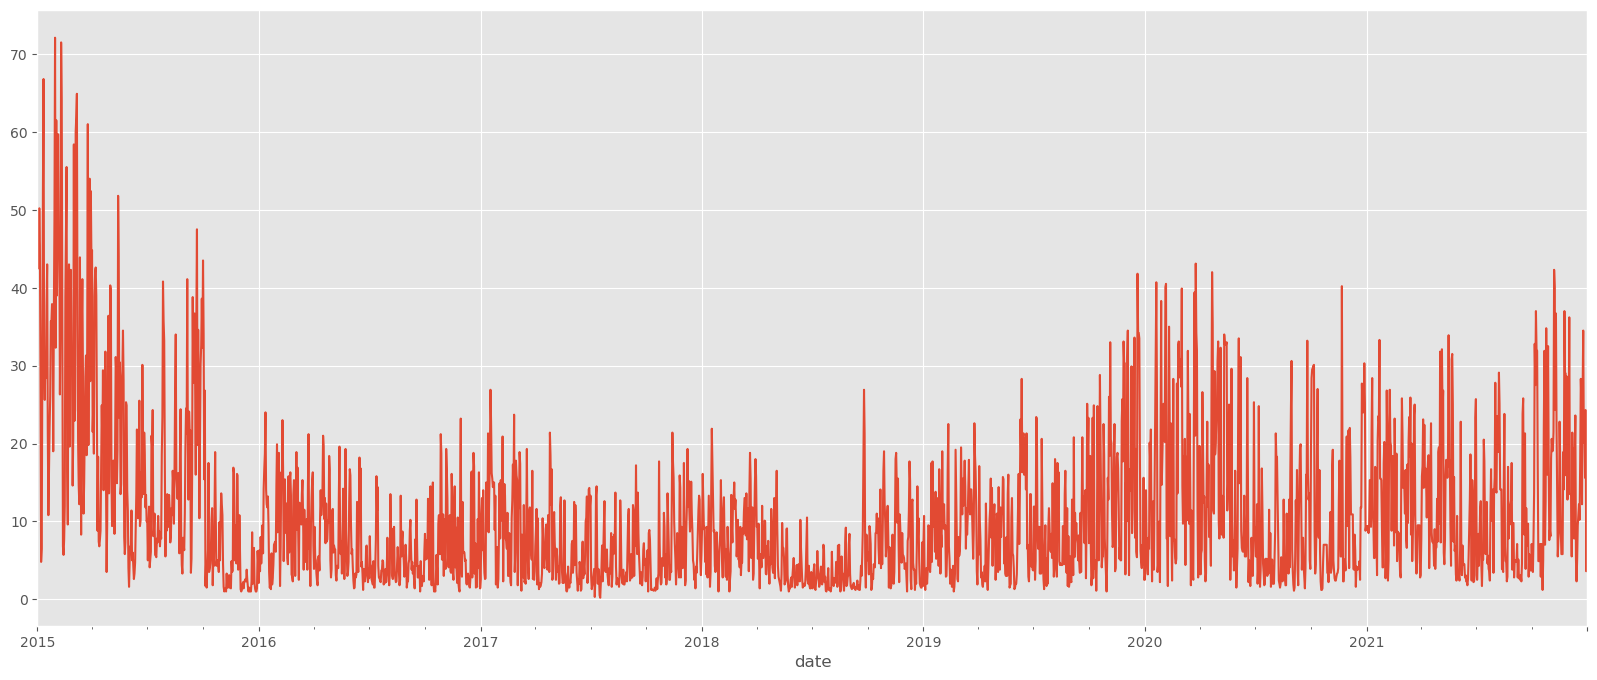

In [9]:
df.energy.plot(figsize=(20,8))

<Axes: xlabel='date'>

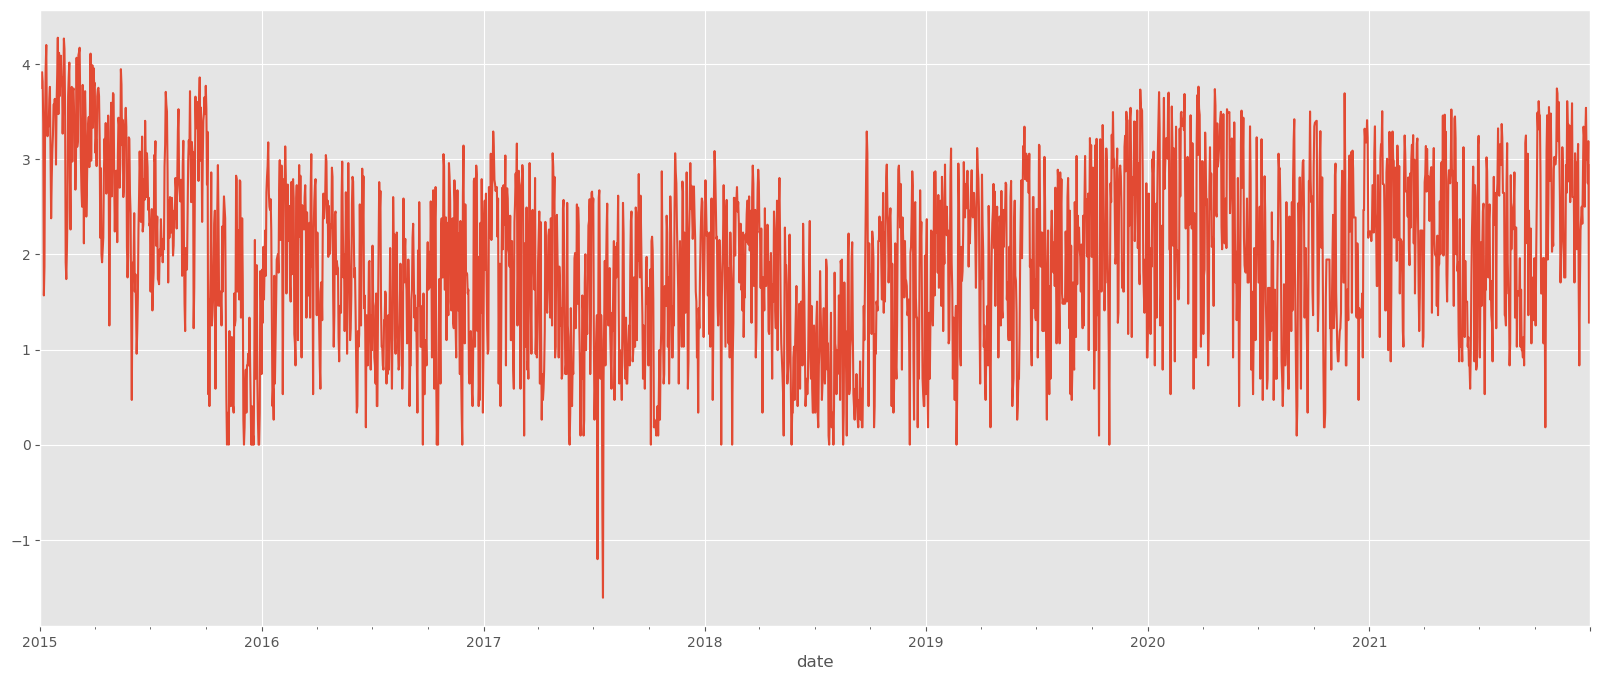

In [10]:
np.log(df.energy).plot(figsize=(20,8))

In [11]:
df.index

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='date', length=2557, freq=None)

### Additive decomposition

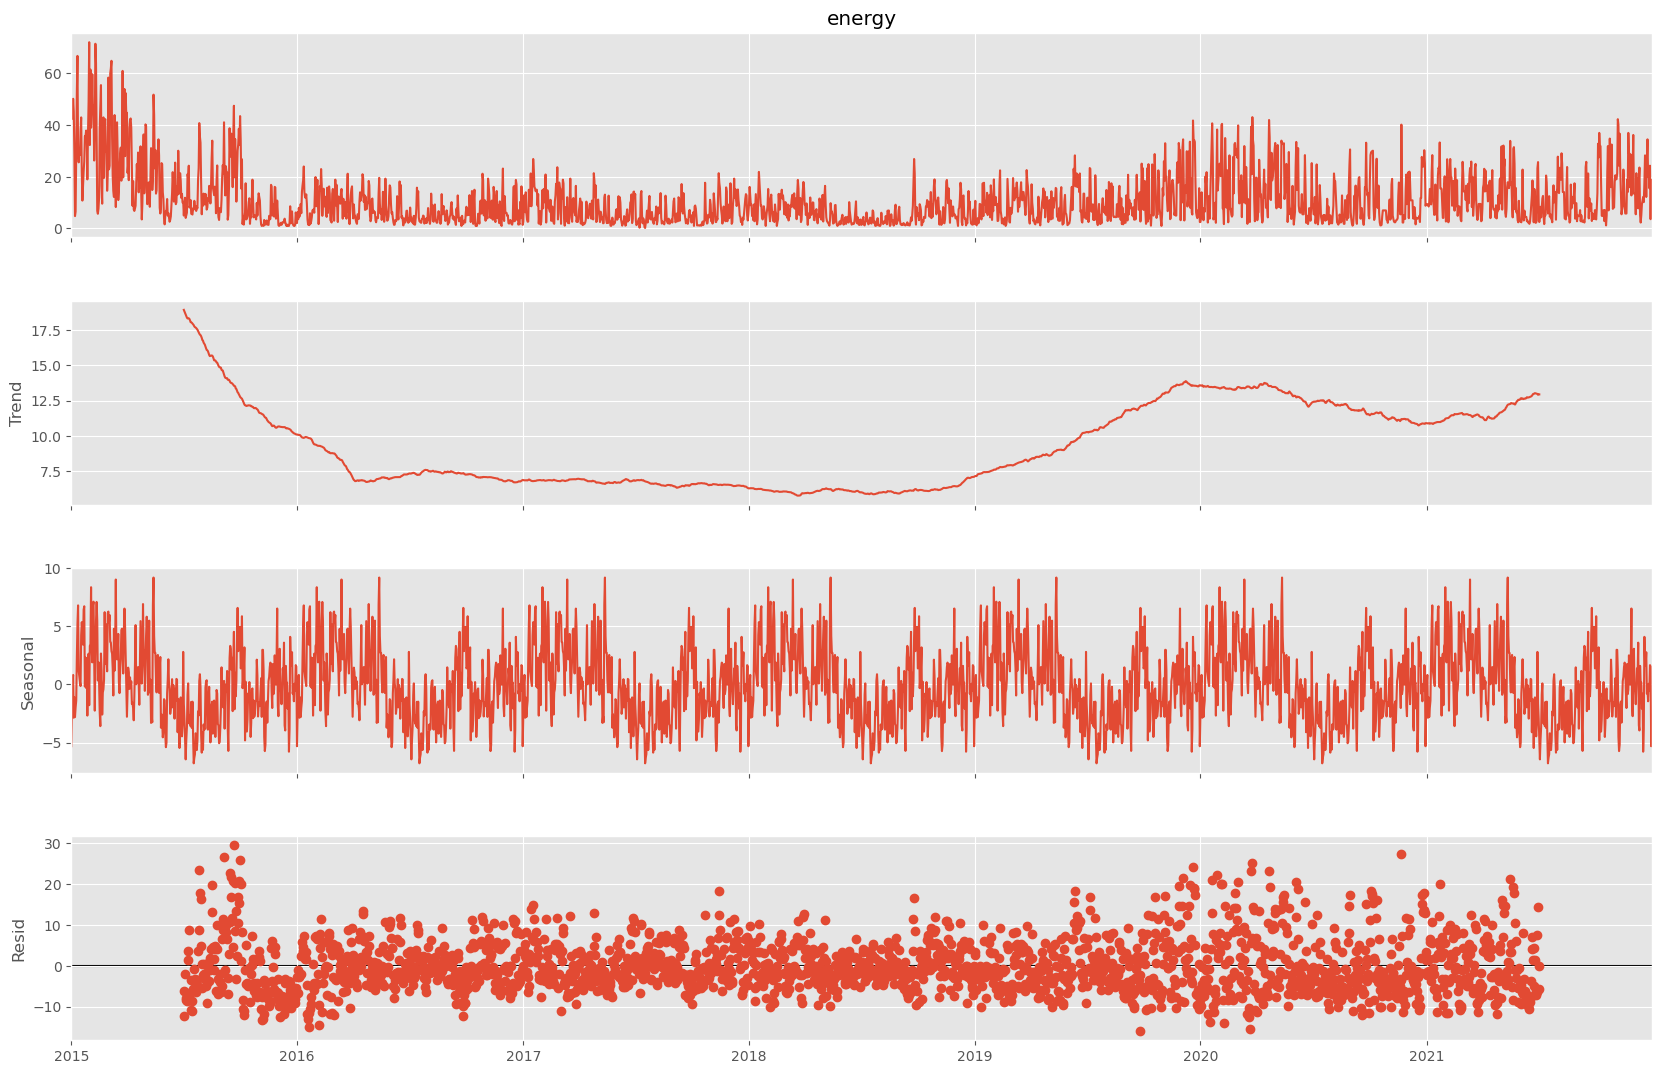

In [12]:
res = seasonal_decompose(df.energy, model='additive', period=365)
fig = res.plot()
fig.set_size_inches((18,12))
plt.show()

### Multiplicative decomposition

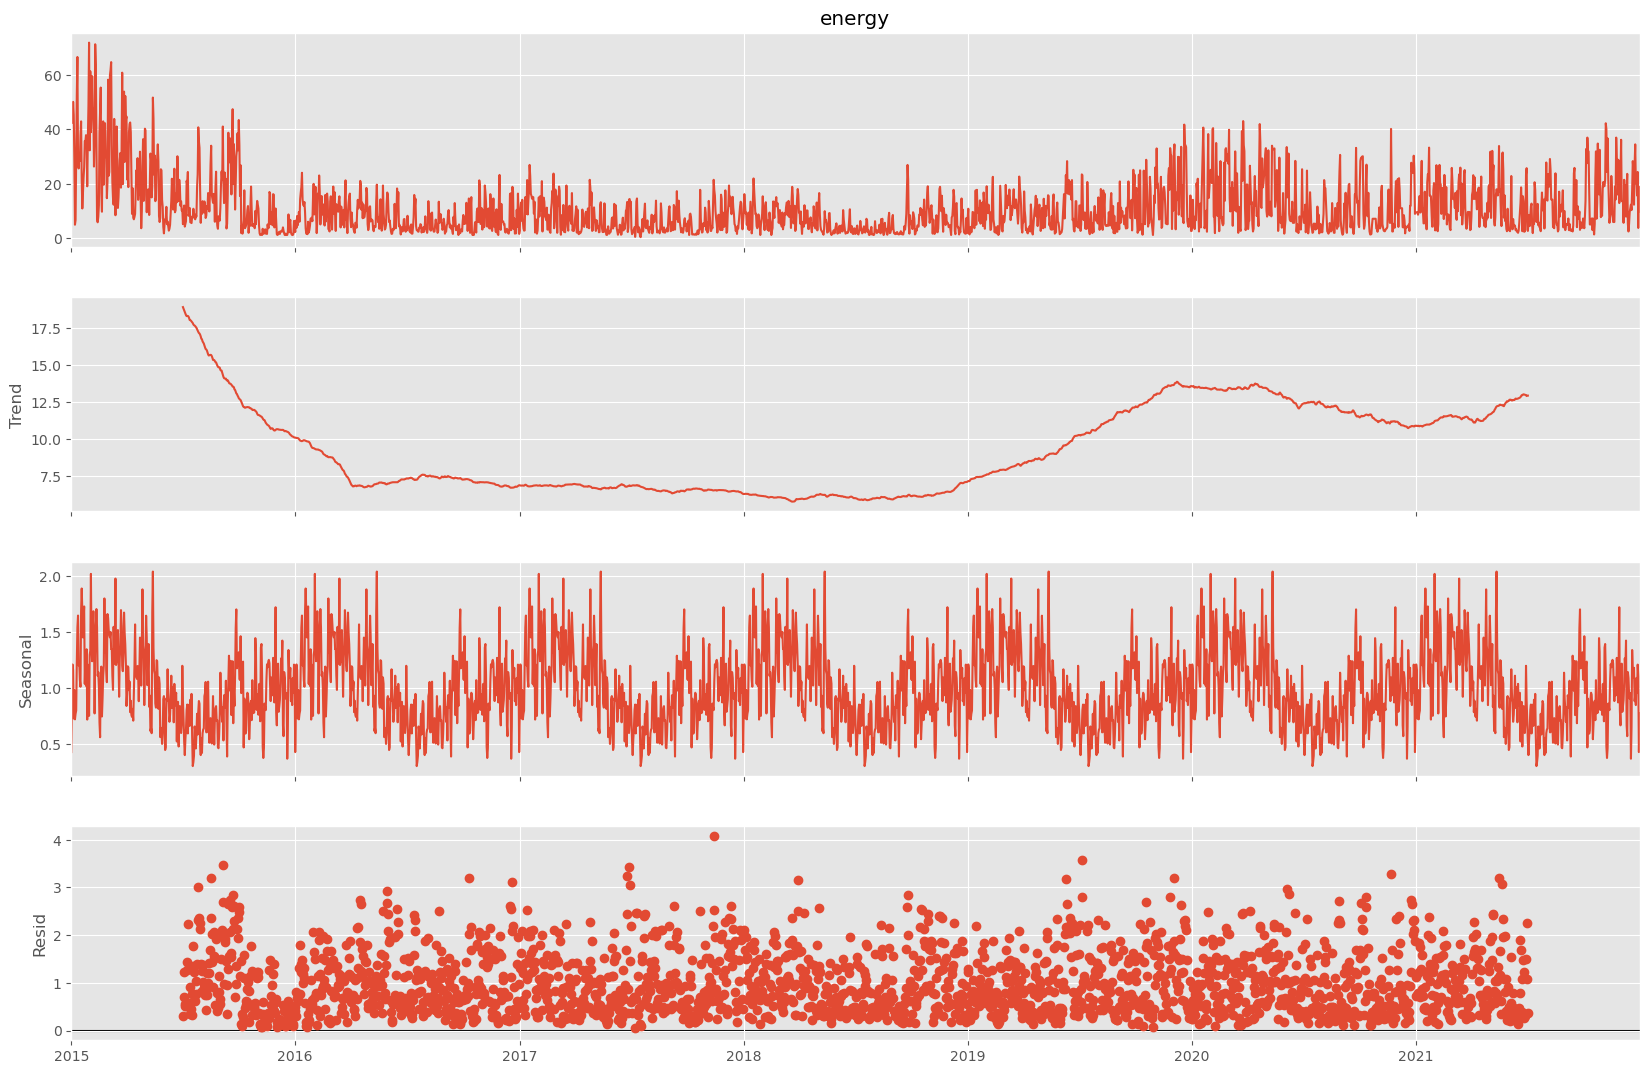

In [13]:
res = seasonal_decompose(df.energy, model='multiplicative', period=365)
fig = res.plot()
fig.set_size_inches((18,12))
plt.show()

### Additive decomposition of the log series

Let us decompose the series.

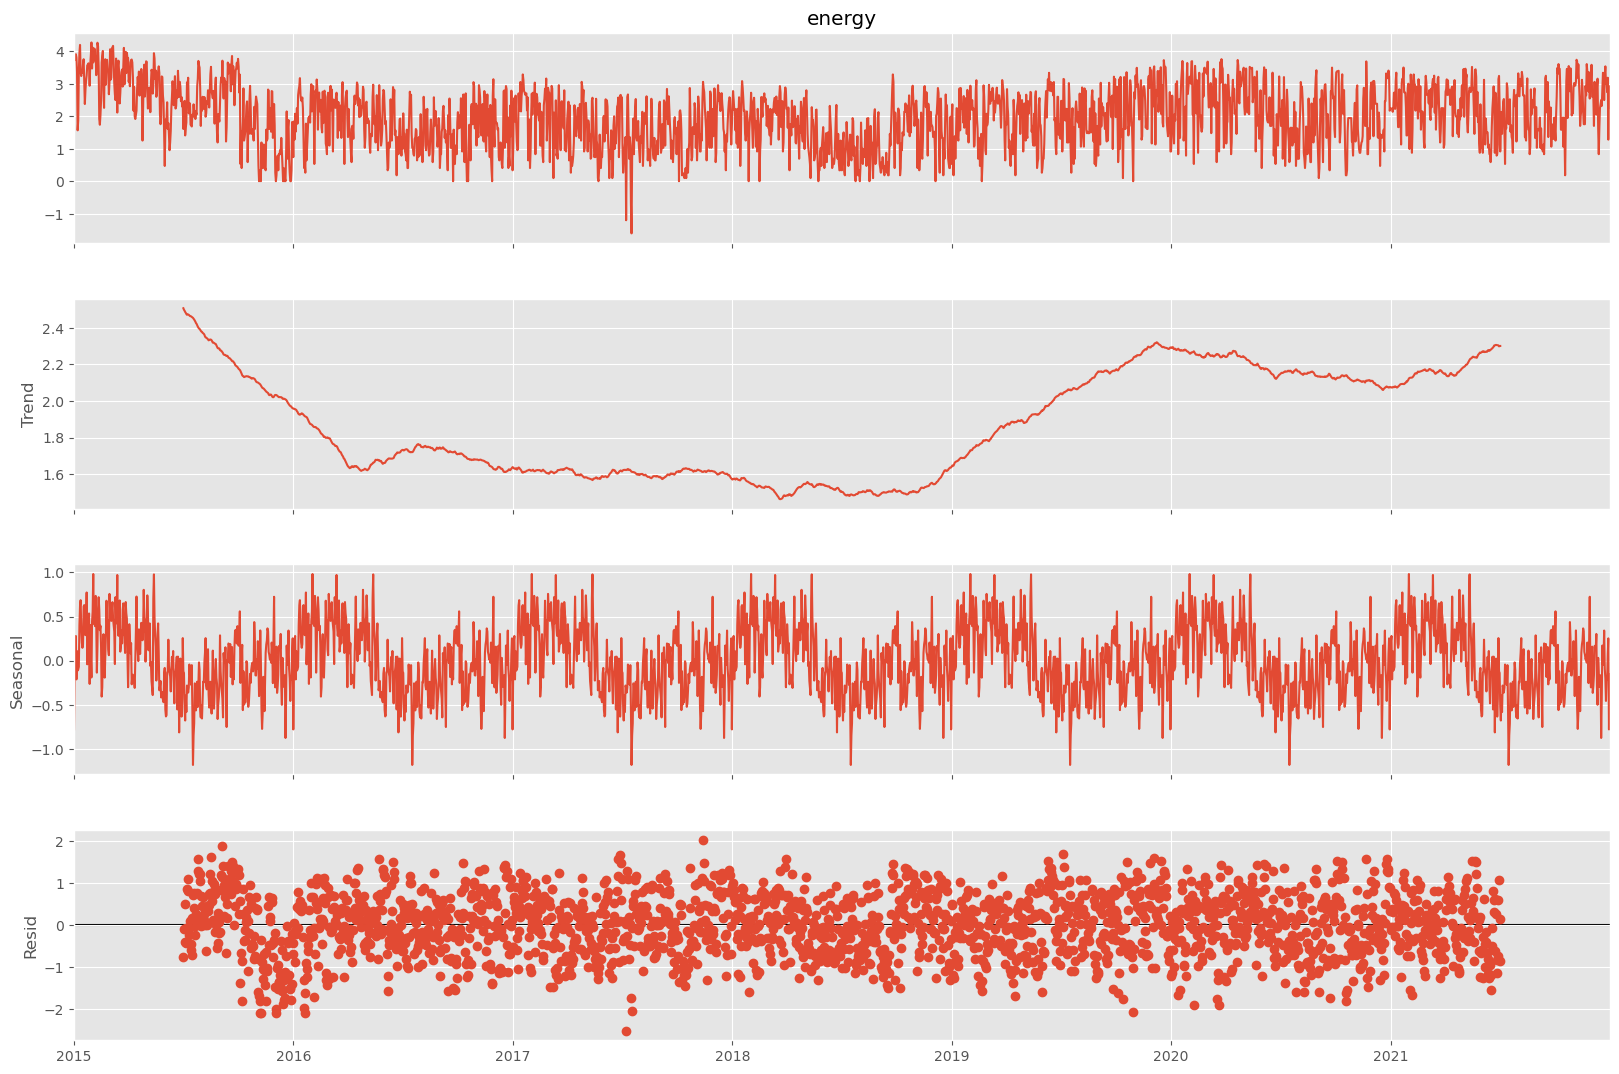

In [14]:
dflog = np.log(df.loc[df.year < 2022, 'energy'])

res = seasonal_decompose(dflog, model='additive', period=365)
fig = res.plot()
fig.set_size_inches((18,12))
plt.show()

Let us smooth the trend a little.

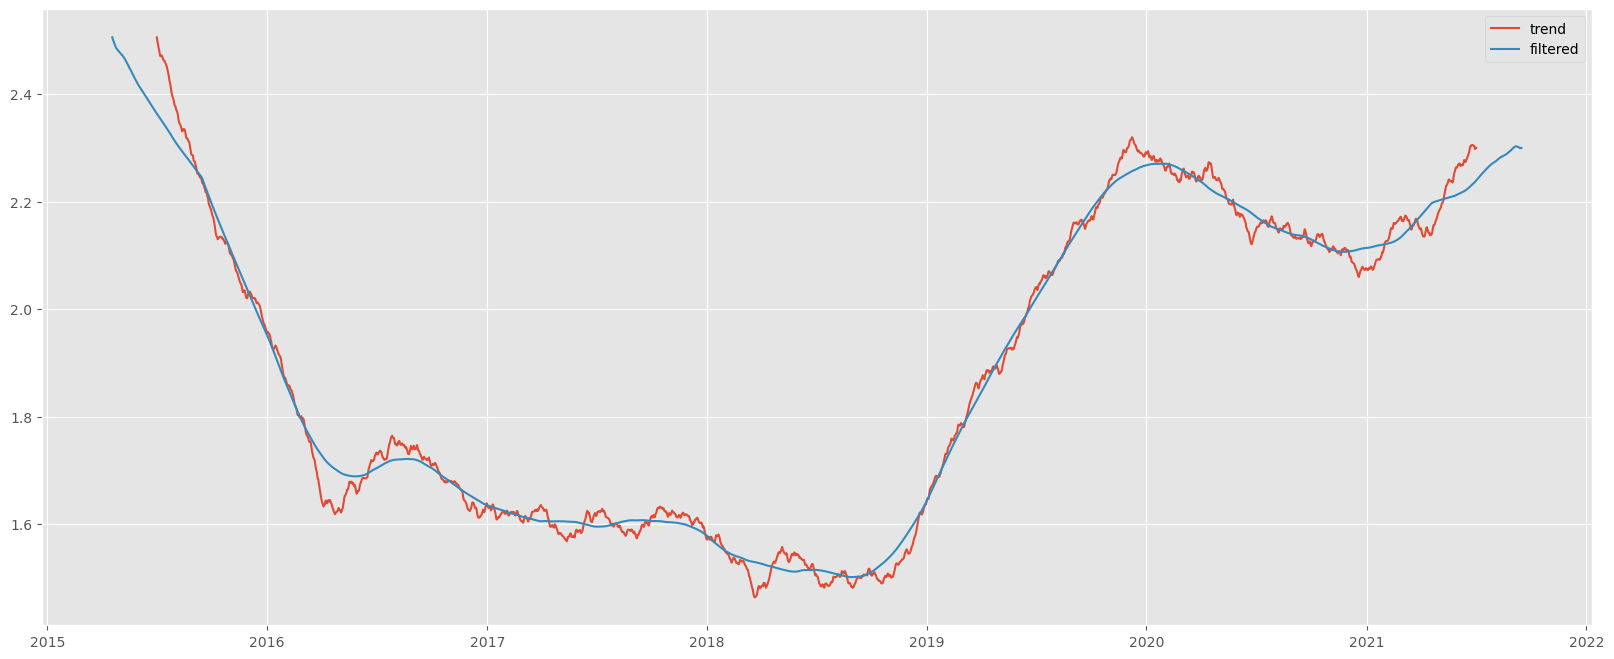

In [15]:
x_filtered = res.trend.rolling(150, min_periods=1, center=True).mean()

plt.figure(figsize=(20,8))
plt.plot(res.trend, label='trend')
plt.plot(x_filtered, label='filtered')
plt.legend()
plt.show()

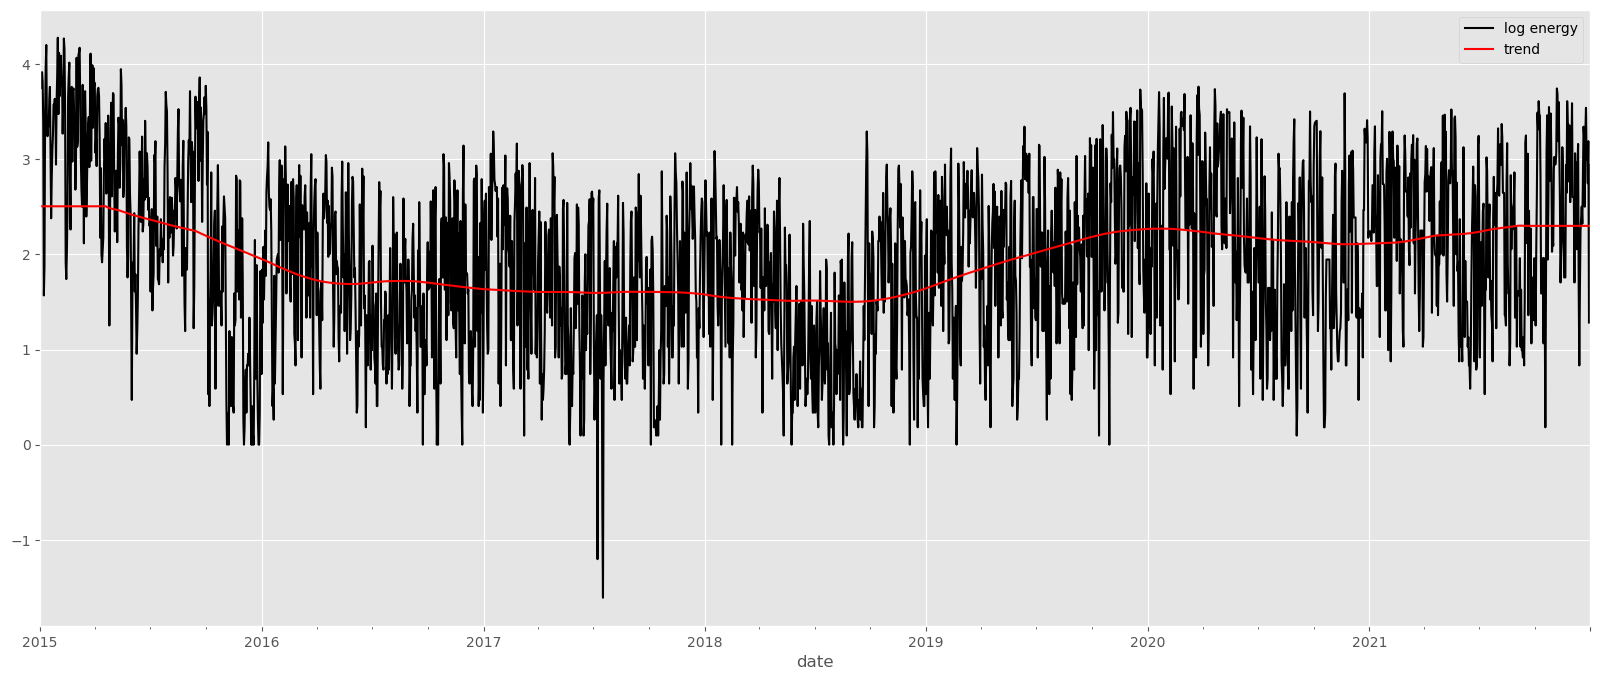

In [16]:
trend = x_filtered
trend = trend.fillna(method='ffill').fillna(method='bfill')

plt.figure(figsize=(20,8))
dflog.plot(color='black', label='log energy')
trend.plot(color='red', label='trend')
plt.legend()
plt.show()

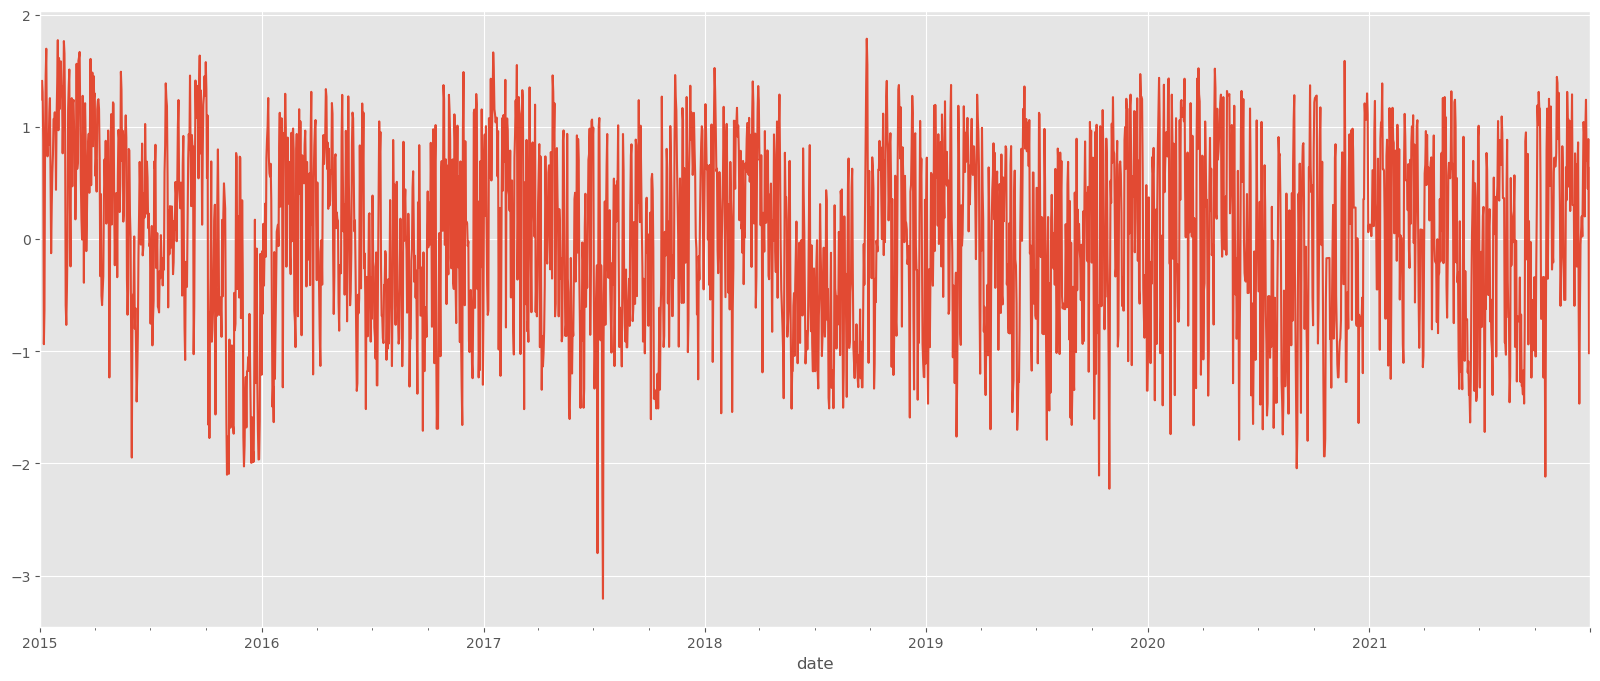

In [17]:
detrended = dflog - trend
detrended.plot(figsize=(20,8))
plt.show()

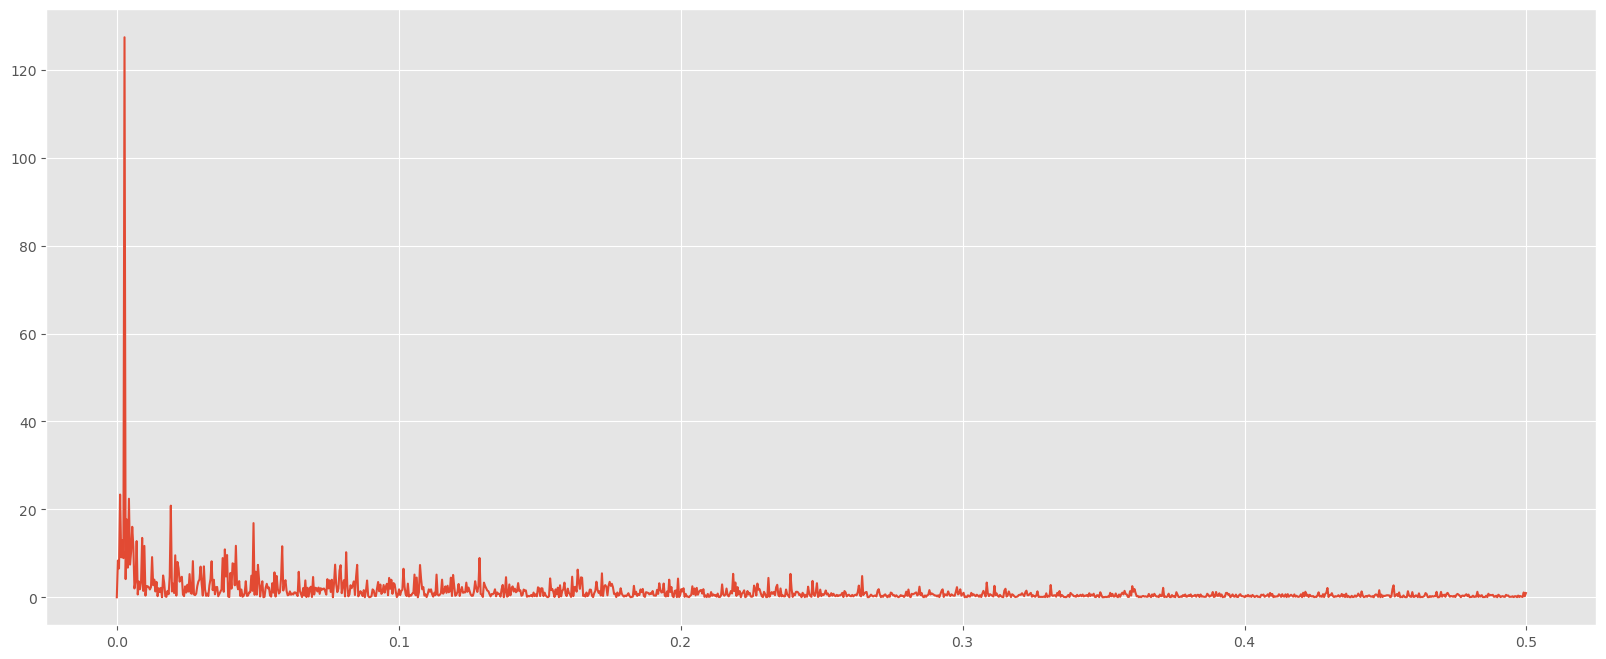

[365.28571429]


In [18]:
f, Pxx_den = periodogram(detrended)
fig = plt.figure(figsize=(20,8))
fig = plt.plot(f,Pxx_den)
plt.show()

freq = f[Pxx_den > 120]

T = 1/freq
print(T)

In [19]:
res1 = detrended.diff(365).dropna()

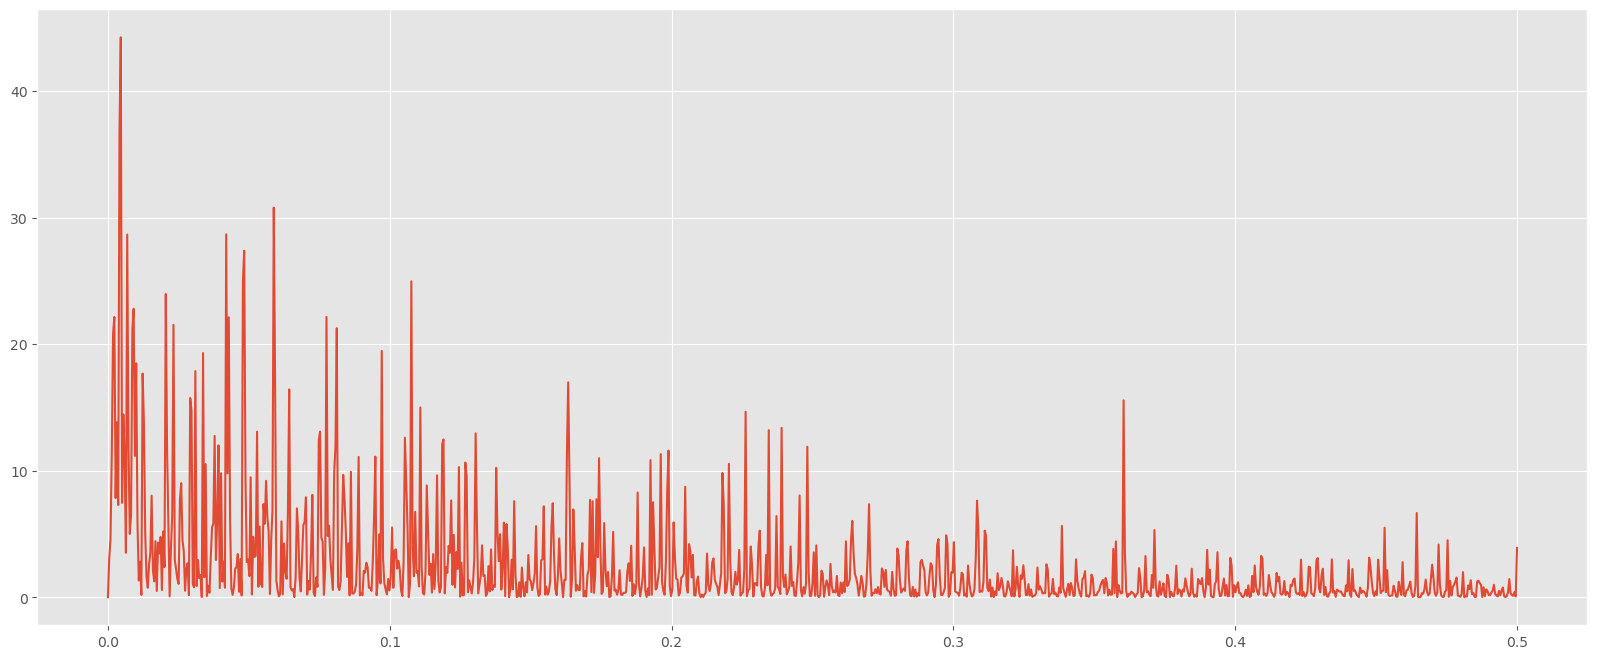

[219.2]


In [20]:
f, Pxx_den = periodogram(res1)
fig = plt.figure(figsize=(20,8))
fig = plt.plot(f,Pxx_den)
plt.show()

#freq = f[(Pxx_den > 40) & (Pxx_den < 50)]
freq = f[Pxx_den > 40]

T = 1/freq
print(T)

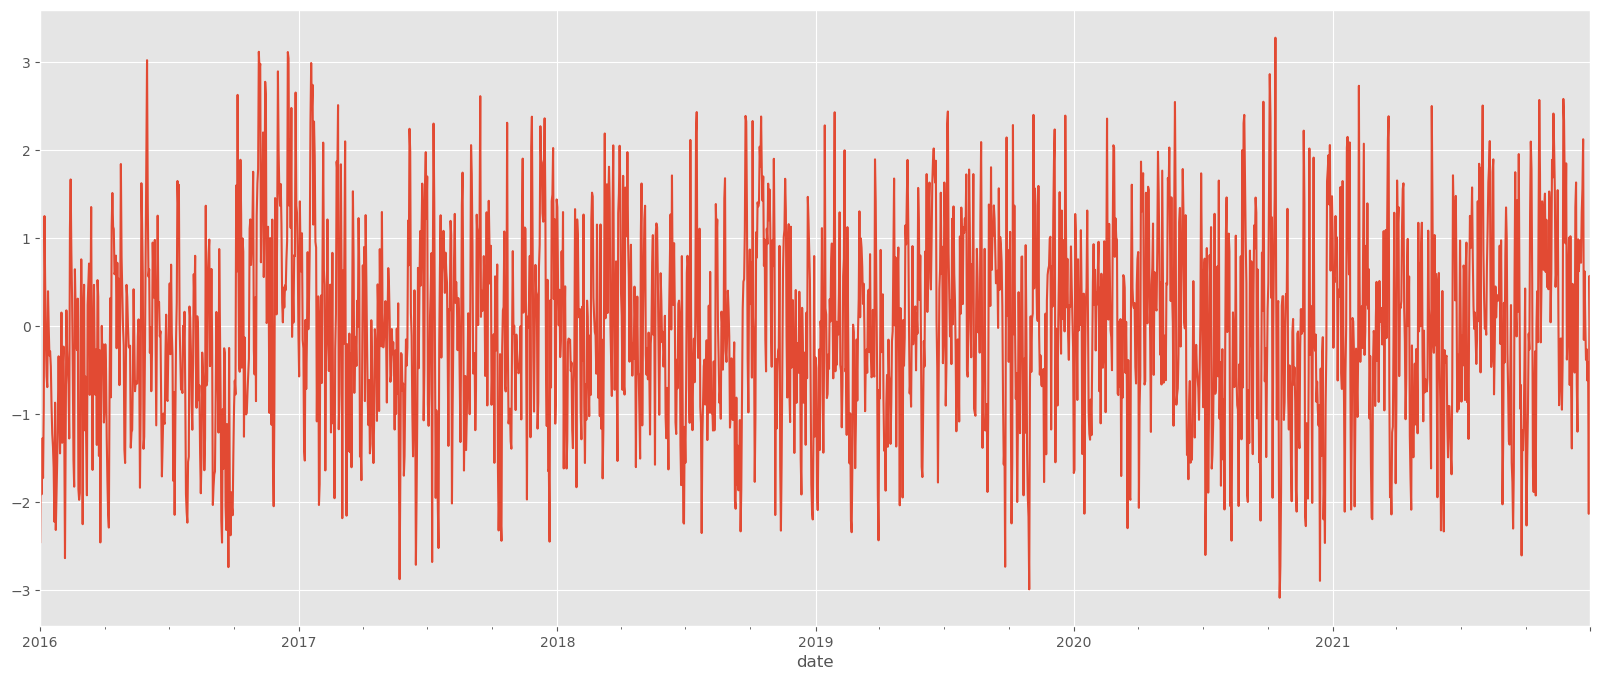

In [21]:
res1.plot(figsize=(20,8))
plt.show()

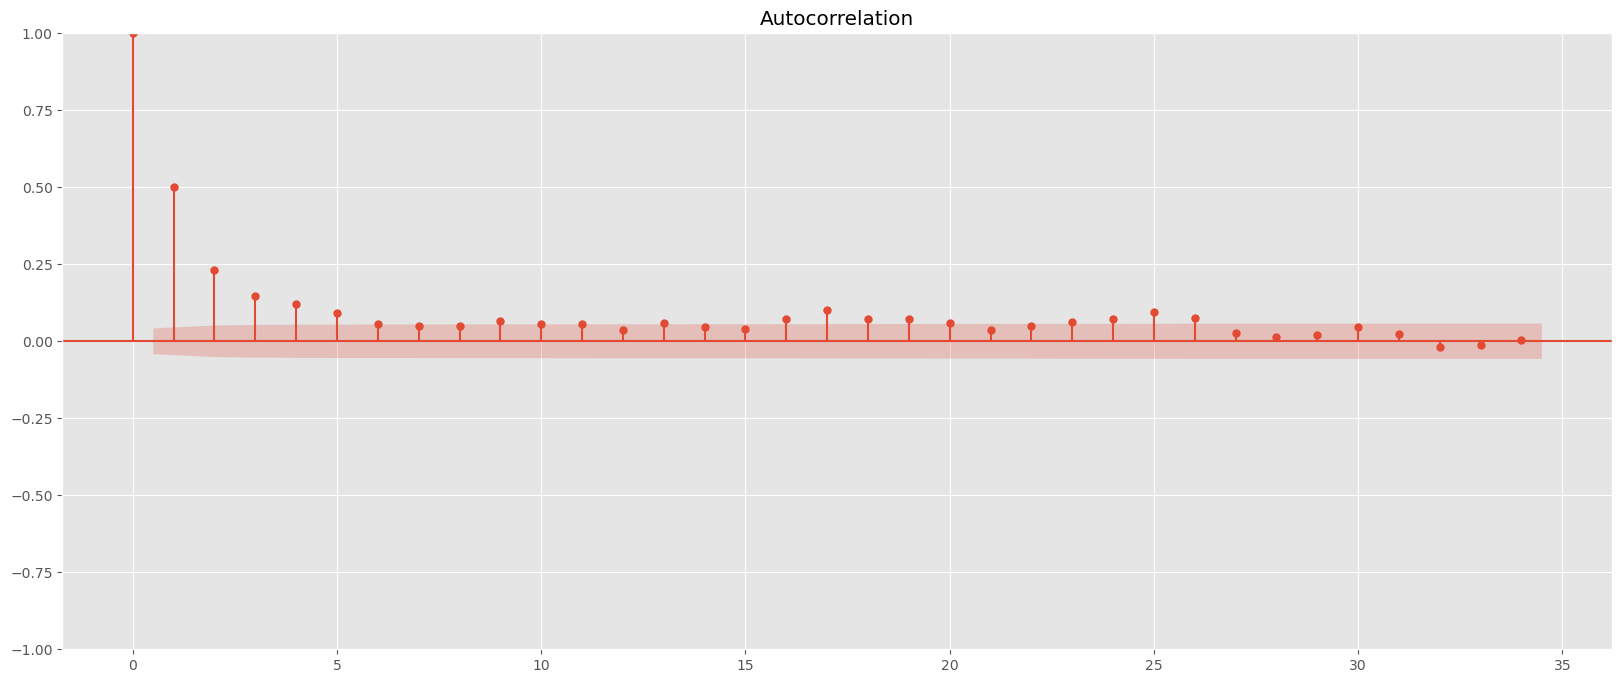

In [22]:
fig = plot_acf(res1)
fig.set_size_inches(20,8)
plt.show()

---------------

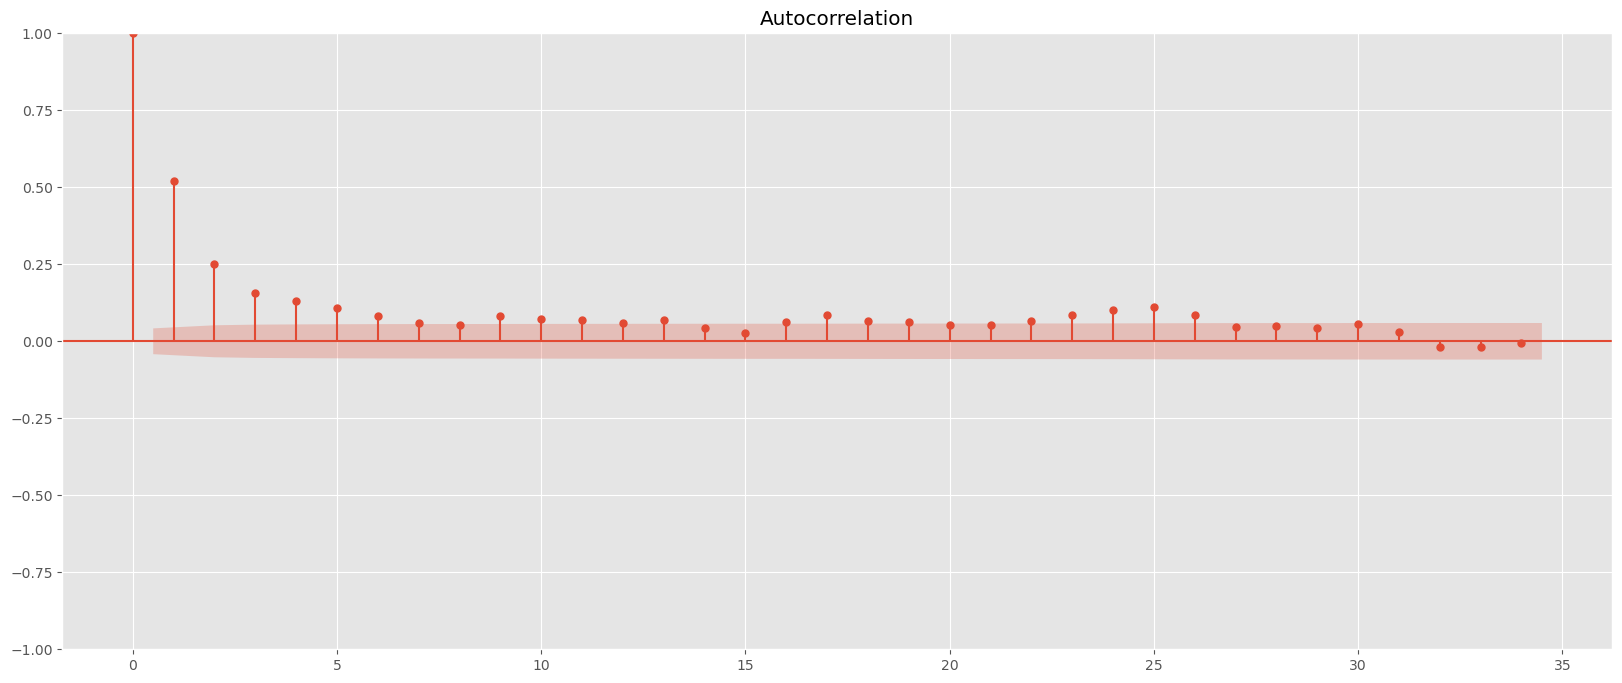

In [23]:
fig = plot_acf(res.resid.dropna())
fig.set_size_inches(20,8)
plt.show()

<Axes: xlabel='date'>

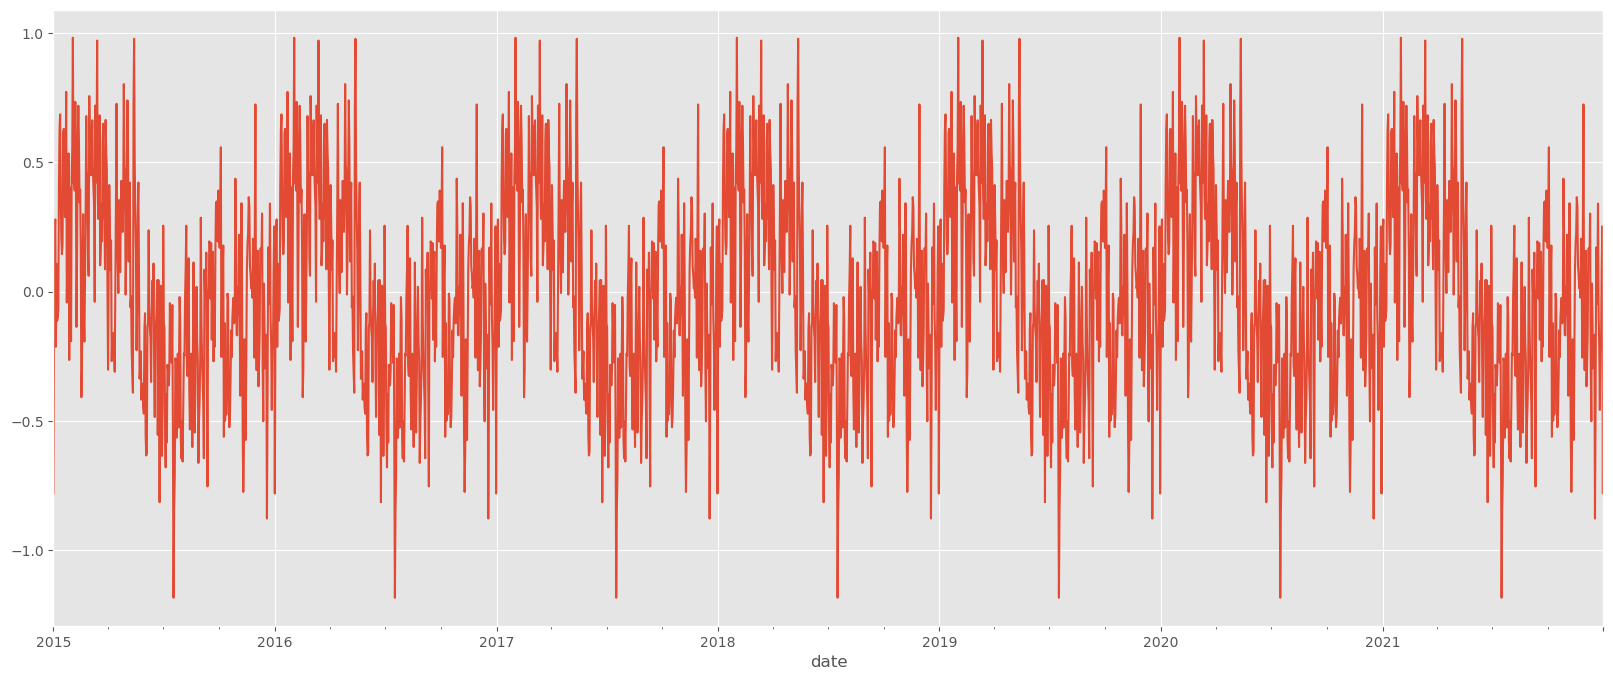

In [24]:
res.seasonal.plot(figsize=(20,8))

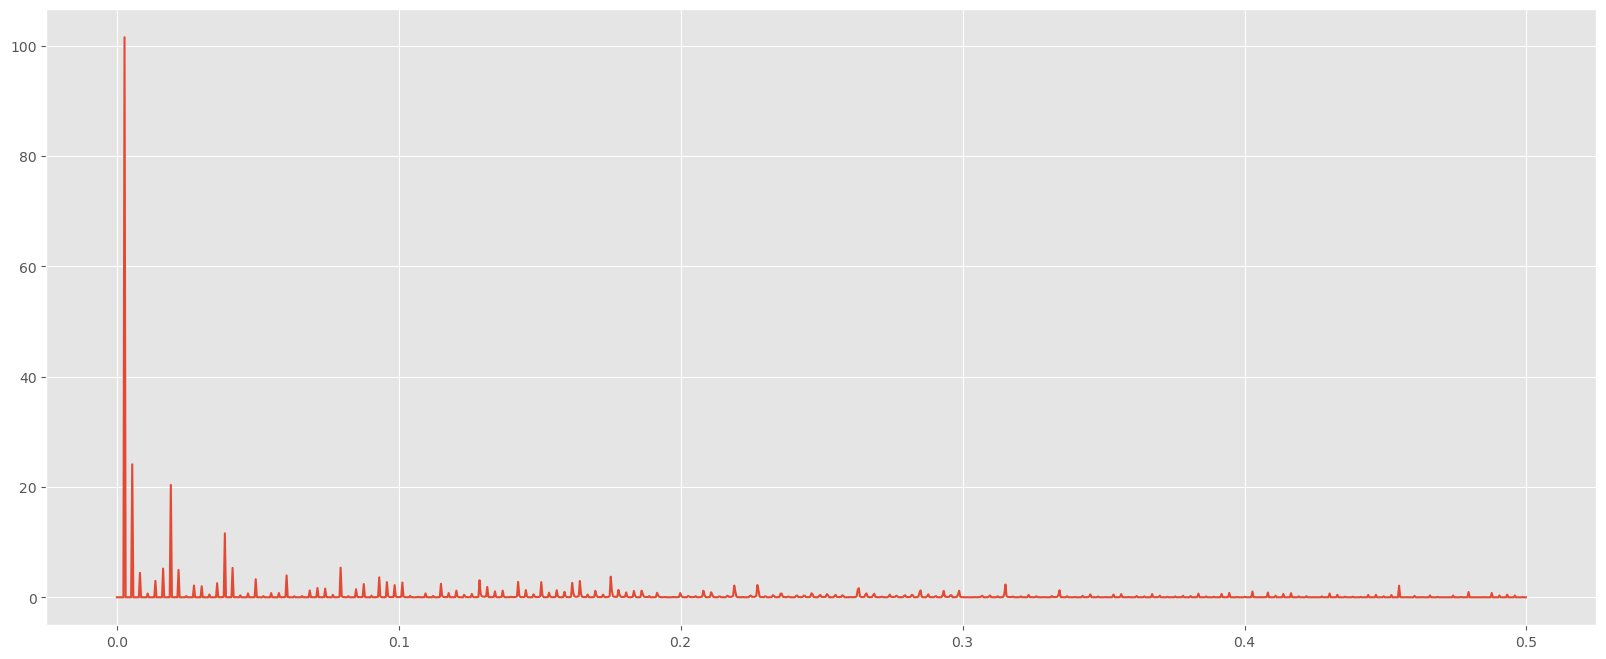

In [25]:
f, Pxx_den = periodogram(res.seasonal)
fig = plt.figure(figsize=(20,8))
fig = plt.plot(f,Pxx_den)
plt.show()

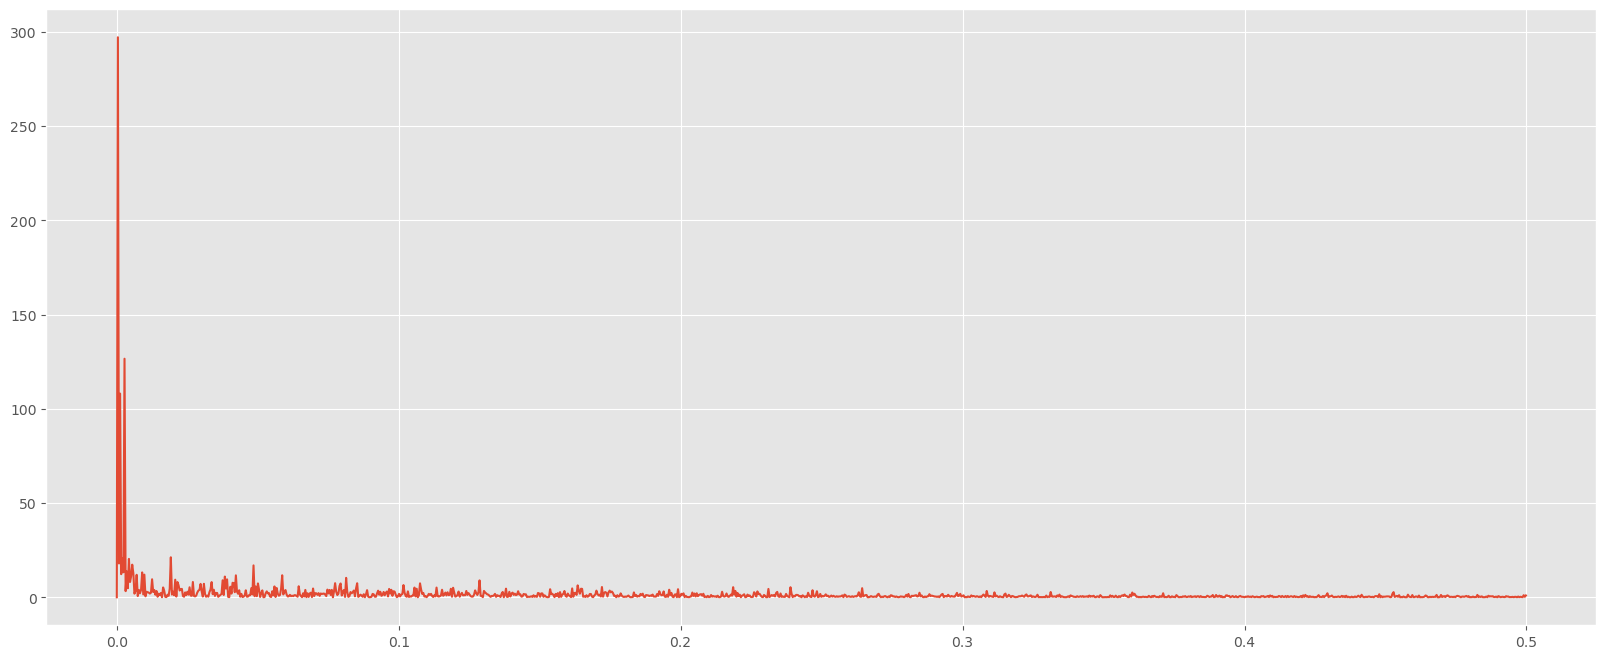

In [26]:
f, Pxx_den = periodogram(np.log(df.energy))
fig = plt.figure(figsize=(20,8))
fig = plt.plot(f,Pxx_den)
plt.show()

In [27]:
freq = f[Pxx_den > 350]

T = 1/freq
print(T)

[]


In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [10]:
def deseasonalize_time_series(time_series, periodicity=365):
    """
    Deseasonalize a time series using seasonal decomposition.

    Parameters:
    -----------
    time_series : array-like
        The input time series data.

    periodicity : int, optional
        The periodicity of the seasonality. Default is 365 for daily data.

    Returns:
    --------
    deseasonalized_series : array-like
        The deseasonalized time series data.

    Examples:
    ----------
    >>> import numpy as np
    >>> time_series = np.random.rand(365) + 10 * np.sin(2 * np.pi * np.arange(365) / 365)
    >>> deseasonalized = deseasonalize_time_series(time_series)
    """
    # Ensure time_series is a pandas Series
    if not isinstance(time_series, pd.Series):
        time_series = pd.Series(time_series)

    # Perform seasonal decomposition
    decomposition = sm.tsa.seasonal_decompose(time_series, period=periodicity)
    
    # Deseasonalize by subtracting the seasonal component
    deseasonalized_series = time_series - decomposition.seasonal
    
    return deseasonalized_series


In [ ]:
import numpy as np

def deseasonalize_fourier(time_series, periodicity=365, num_harmonics=10):
    """
    Deseasonalize a time series using Fourier decomposition.

    Parameters:
    -----------
    time_series : array-like
        The input time series data.

    periodicity : int, optional
        The periodicity of the seasonality. Default is 365 for daily data.

    num_harmonics : int, optional
        The number of harmonics to use in Fourier decomposition. Default is 10.

    Returns:
    --------
    deseasonalized_series : array-like
        The deseasonalized time series data.

    Examples:
    ----------
    >>> import numpy as np
    >>> time_series = np.random.rand(365) + 10 * np.sin(2 * np.pi * np.arange(365) / 365)
    >>> deseasonalized = deseasonalize_fourier(time_series)
    """
    # Ensure time_series is a numpy array
    time_series = np.array(time_series)

    n = len(time_series)
    t = np.arange(n)
    frequencies = np.fft.fftfreq(n)

    # Find the indices of the frequencies corresponding to the seasonal component
    seasonal_indices = np.abs(frequencies - 1 / periodicity) < 1e-6

    # Compute the Fourier coefficients for the seasonal component
    seasonal_coefficients = np.fft.fft(time_series)[seasonal_indices]

    # Create the deseasonalized time series by subtracting the seasonal component
    deseasonalized_series = time_series - np.sum(
        np.outer(seasonal_coefficients, np.sin(2 * np.pi * t * frequencies[seasonal_indices])),
        axis=0,
    )

    return deseasonalized_series


In [11]:
# Generate a sample time series with a 365-day seasonality
time_series = np.random.rand(365) + 10 * np.sin(2 * np.pi * np.arange(365) / 365)

# Deseasonalize the time series
deseasonalized_series = deseasonalize_time_series(time_series)

ValueError: x must have 2 complete cycles requires 730 observations. x only has 365 observation(s)